## 5 - Performance Analysis

##### Import

In [1]:
import os
import ast
import pandas as pd
import numpy as np
import scipy as su
# from typing import Dict
# from scipy.signal import
# from scikit-learn import

from matplotlib.path import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import dask.dataframe as dd

import pingouin as pg
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
import scipy.stats as stats
import pingouin as pg
from scipy.stats import ttest_rel
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import boxcox
from scipy.stats import friedmanchisquare
from scipy.stats import shapiro, levene

##### Data Loading

In [3]:
# Load AoI ddfs into dictionary
root_dir = './aoi_data'
def load_aoi_data(root_dir): # Get csv file reads into one dictionary
    data = {}
    for file in os.listdir(root_dir):
        file_path = os.path.join(root_dir, file)
        file_name = os.path.splitext(file)[0]  # file name without '.csv'
        data[file_name] = dd.read_csv(file_path)  # read and attach to dict
    return data

data = load_aoi_data(root_dir)
participant_ids = [1,2,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20]

quest_df = data['quest'].iloc[:, 1:].compute()
gui_df = data['gui'].compute()

In [4]:
# Condition labelling
cond_mapping = {
    1: 'Easy Slow',
    2: 'Easy Fast',
    3: 'Hard Slow',
    4: 'Hard Fast',
    5: 'Easy Slow',
    6: 'Easy Fast',
    7: 'Hard Slow',
    8: 'Hard Fast'
}
diff_mapping = {
    1: 'Easy',
    2: 'Easy',
    3: 'Hard',
    4: 'Hard',
    5: 'Easy',
    6: 'Easy',
    7: 'Hard',
    8: 'Hard'
}
freq_mapping = {
    1: 'Slow',
    2: 'Fast',
    3: 'Slow',
    4: 'Fast',
    5: 'Slow',
    6: 'Fast',
    7: 'Slow',
    8: 'Fast'
}
gui_df['condition'] = gui_df['block_type'].map(cond_mapping)
gui_df['difficulty'] = gui_df['block_type'].map(diff_mapping)
gui_df['frequency'] = gui_df['block_type'].map(freq_mapping)
quest_df['condition'] = quest_df['block_type'].map(cond_mapping)
quest_df['difficulty'] = quest_df['block_type'].map(diff_mapping)
quest_df['frequency'] = quest_df['block_type'].map(freq_mapping)

custom_labels = ['Easy Slow', 'Easy Fast', 'Hard Slow', 'Hard Fast']

gui_df = gui_df[['participant_id', 'block_type', 'difficulty', 'frequency', 'condition', 'task_id', 'errors', 'completion_time', 'reaction_time']]

In [5]:
# Average by condition
errors_df = gui_df.groupby(['participant_id', 'block_type', 'difficulty', 'frequency', 'condition'])['errors'].mean().reset_index()
compl_time_df = gui_df.groupby(['participant_id', 'block_type', 'difficulty', 'frequency', 'condition'])['completion_time'].mean().reset_index()
react_time_df = gui_df.groupby(['participant_id', 'block_type', 'difficulty', 'frequency', 'condition'])['reaction_time'].mean().reset_index()

errors_compl_time_df = pd.merge(errors_df, compl_time_df, on=['participant_id', 'block_type', 'difficulty', 'frequency', 'condition'], how='left')
df = pd.merge(errors_compl_time_df, react_time_df, on=['participant_id', 'block_type', 'difficulty', 'frequency', 'condition'], how='left')

In [6]:
# Long format
errors_df = gui_df.groupby(['participant_id', 'difficulty', 'frequency', 'condition'])['errors'].mean().reset_index()
compl_time_df = gui_df.groupby(['participant_id', 'difficulty', 'frequency', 'condition'])['completion_time'].mean().reset_index()
react_time_df = gui_df.groupby(['participant_id', 'difficulty', 'frequency', 'condition'])['reaction_time'].mean().reset_index()

errors_compl_time_df = pd.merge(errors_df, compl_time_df, on=['participant_id', 'difficulty', 'frequency', 'condition'], how='left')
df_long = pd.merge(errors_compl_time_df, react_time_df, on=['participant_id', 'difficulty', 'frequency', 'condition'], how='left')

df_long['difficulty'] = df_long['difficulty'].astype('category')
df_long['frequency'] = df_long['frequency'].astype('category')

In [7]:
# Variables definitions
dependent_vars = ['errors', 'completion_time', 'reaction_time']
group_vars = ['difficulty', 'frequency']

### 1. Graphs

##### Difficulty & Frequency

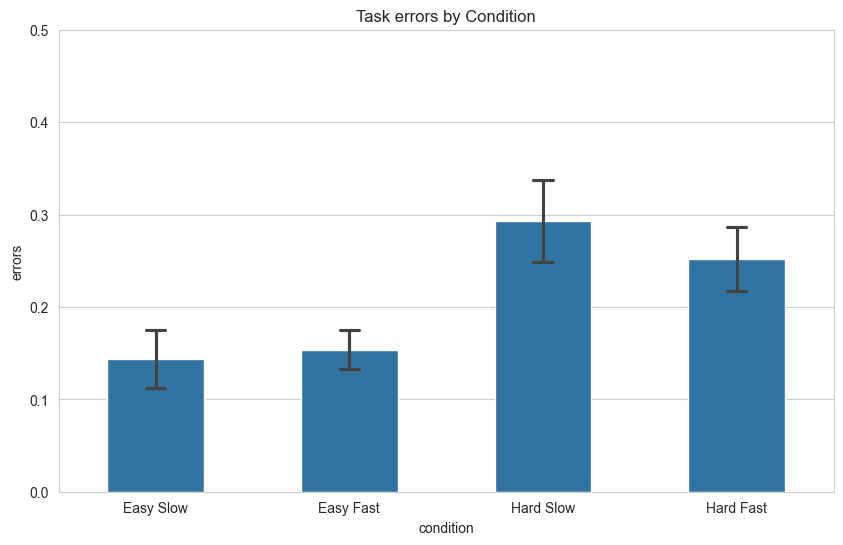

In [59]:
# Errors
plt.figure(figsize=(10,6))
ax=sns.barplot(
    data=gui_df,
    y='errors',
    x = 'condition',
    estimator='mean',
    order=['Easy Slow', 'Easy Fast', 'Hard Slow', 'Hard Fast'],
    errorbar='se',
    capsize=0.1,
    width=0.5,
)
plt.title('Task errors by Condition')
plt.xlabel('condition')
plt.ylabel('errors')
plt.ylim(0, .5)
plt.show()

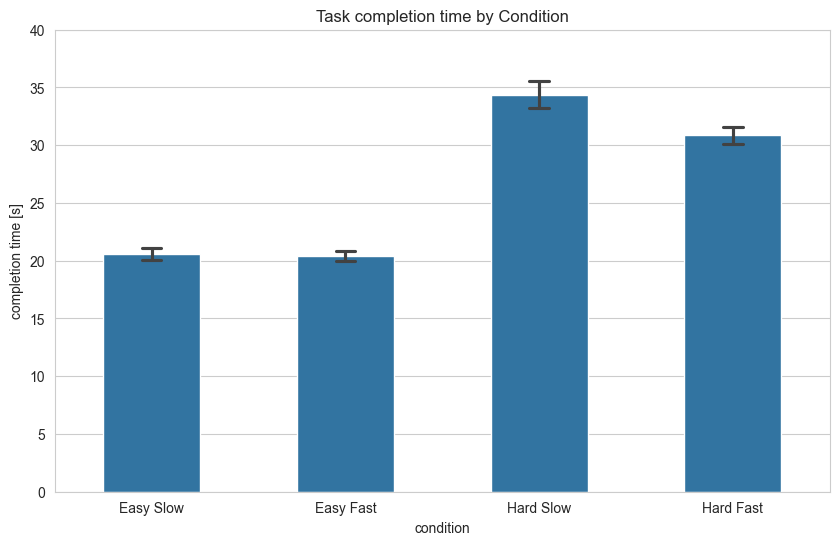

In [60]:
# Completion time
plt.figure(figsize=(10,6))
ax=sns.barplot(
    data=gui_df,
    y='completion_time',
    x = 'condition',
    estimator='mean',
    order=['Easy Slow', 'Easy Fast', 'Hard Slow', 'Hard Fast'],
    errorbar='se',
    capsize=0.1,
    width=0.5,
)
plt.title('Task completion time by Condition')
plt.xlabel('condition')
plt.ylabel('completion time [s]')
plt.ylim(0, 40)
plt.show()

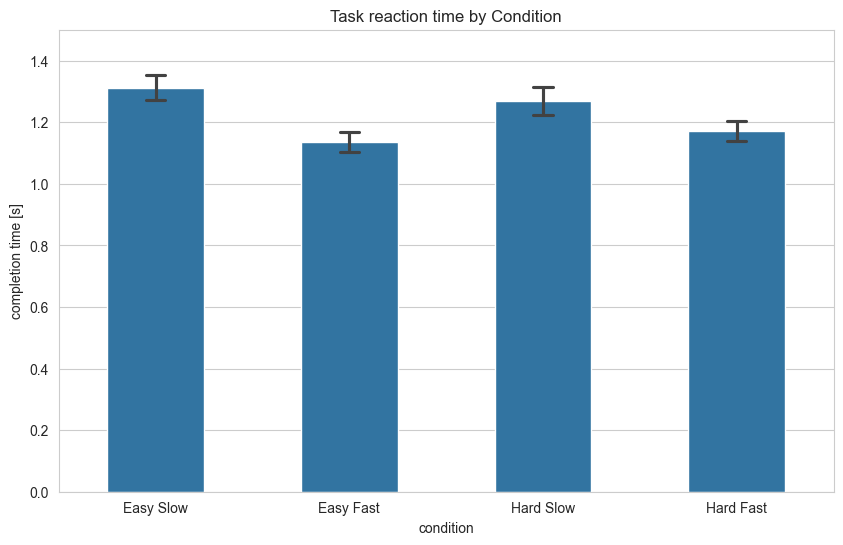

In [61]:
# Reaction time
plt.figure(figsize=(10,6))
ax=sns.barplot(
    data=gui_df,
    y='reaction_time',
    x = 'condition',
    estimator='mean',
    order=['Easy Slow', 'Easy Fast', 'Hard Slow', 'Hard Fast'],
    errorbar='se',
    capsize=0.1,
    width=0.5,
)
plt.title('Task reaction time by Condition')
plt.xlabel('condition')
plt.ylabel('completion time [s]')
plt.ylim(0, 1.5)
plt.show()

##### Difficulty

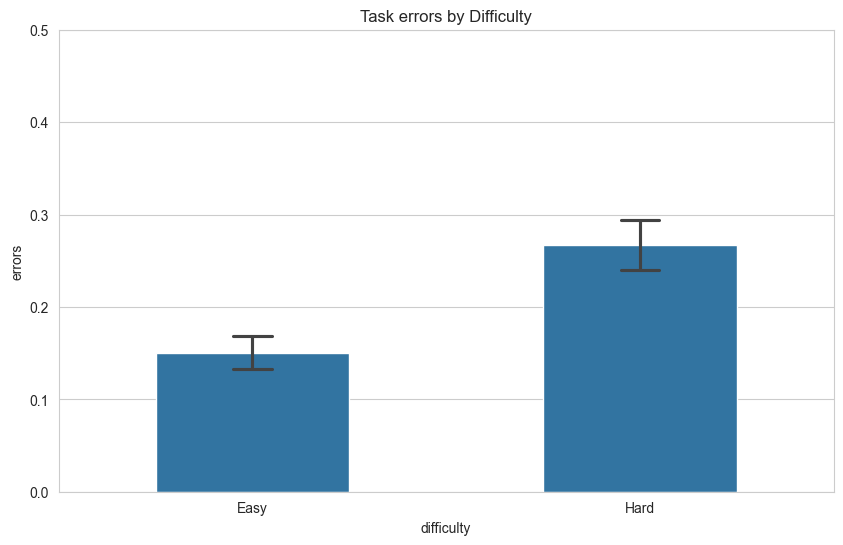

In [62]:
# Errors
plt.figure(figsize=(10,6))
ax=sns.barplot(
    data=gui_df,
    y='errors',
    x = 'difficulty',
    estimator='mean',
    order=['Easy', 'Hard'],
    errorbar='se',
    capsize=0.1,
    width=0.5,
)
plt.title('Task errors by Difficulty')
plt.xlabel('difficulty')
plt.ylabel('errors')
plt.ylim(0, .5)
plt.show()

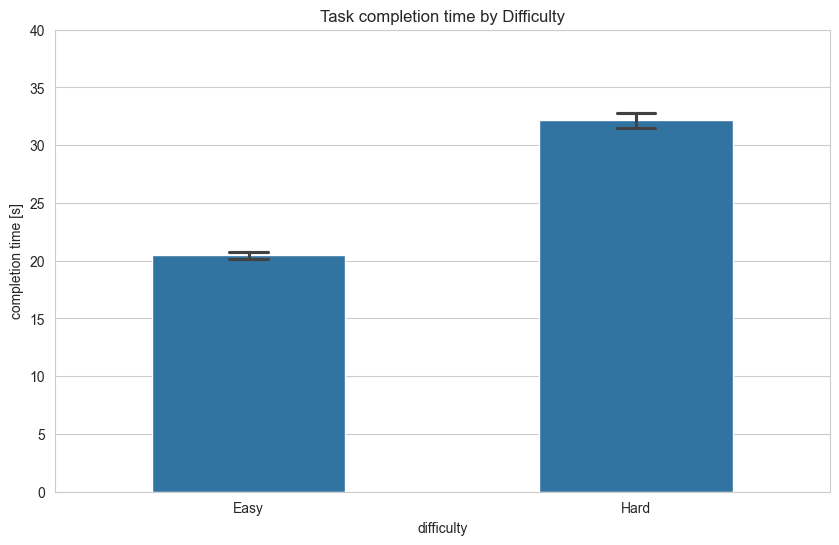

In [63]:
# Completion time
plt.figure(figsize=(10,6))
ax=sns.barplot(
    data=gui_df,
    y='completion_time',
    x = 'difficulty',
    estimator='mean',
    order=['Easy', 'Hard'],
    errorbar='se',
    capsize=0.1,
    width=0.5,
)
plt.title('Task completion time by Difficulty')
plt.xlabel('difficulty')
plt.ylabel('completion time [s]')
plt.ylim(0, 40)
plt.show()

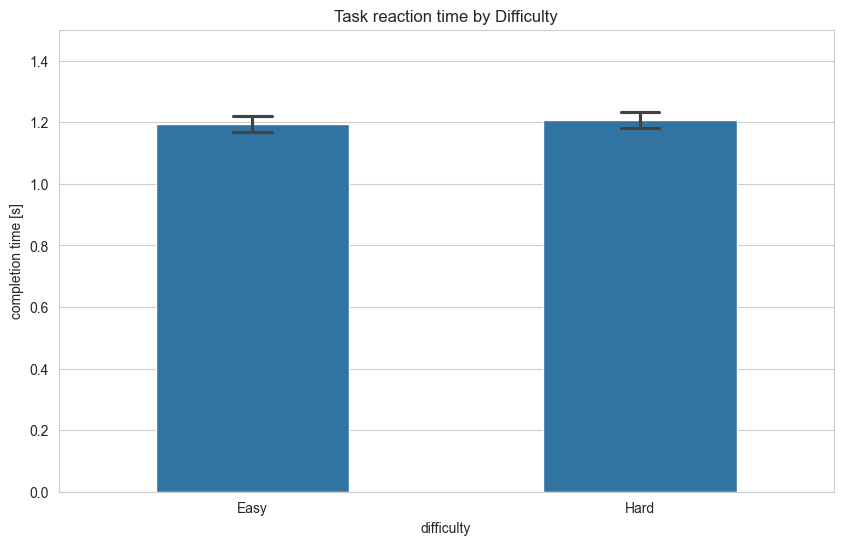

In [64]:
# Reaction time
plt.figure(figsize=(10,6))
ax=sns.barplot(
    data=gui_df,
    y='reaction_time',
    x = 'difficulty',
    estimator='mean',
    order=['Easy', 'Hard'],
    errorbar='se',
    capsize=0.1,
    width=0.5,
)
plt.title('Task reaction time by Difficulty')
plt.xlabel('difficulty')
plt.ylabel('completion time [s]')
plt.ylim(0, 1.5)
plt.show()

##### Frequency

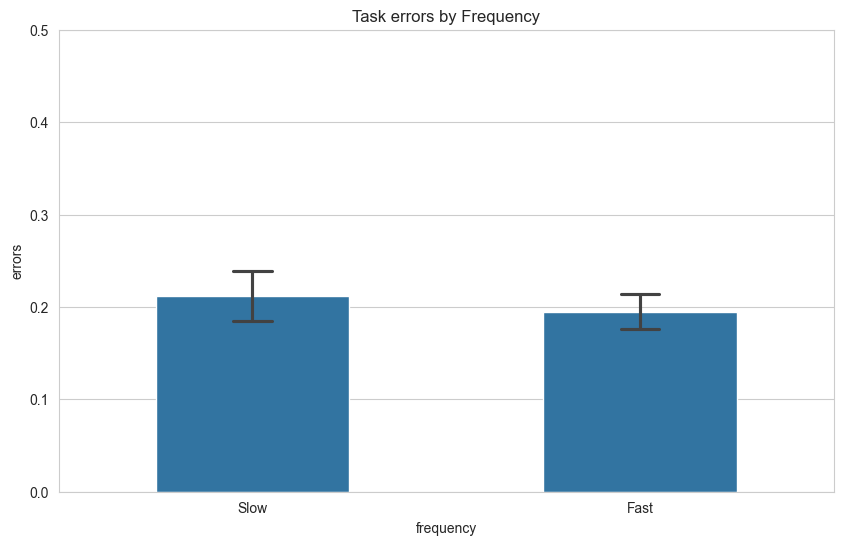

In [65]:
# Errors
plt.figure(figsize=(10,6))
ax=sns.barplot(
    data=gui_df,
    y='errors',
    x = 'frequency',
    estimator='mean',
    order=['Slow', 'Fast'],
    errorbar='se',
    capsize=0.1,
    width=0.5,
)
plt.title('Task errors by Frequency')
plt.xlabel('frequency')
plt.ylabel('errors')
plt.ylim(0, .5)
plt.show()

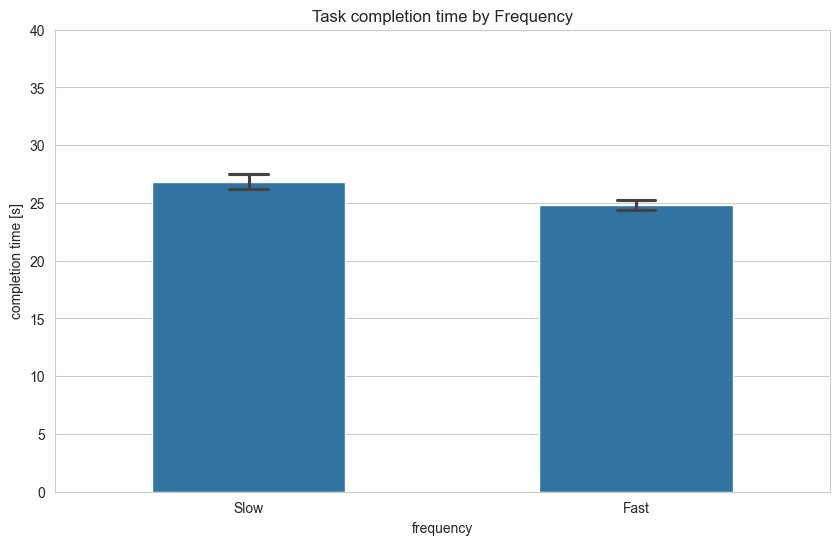

In [66]:
# Completion time
plt.figure(figsize=(10,6))
ax=sns.barplot(
    data=gui_df,
    y='completion_time',
    x = 'frequency',
    estimator='mean',
    order=['Slow', 'Fast'],
    errorbar='se',
    capsize=0.1,
    width=0.5,
)
plt.title('Task completion time by Frequency')
plt.xlabel('frequency')
plt.ylabel('completion time [s]')
plt.ylim(0, 40)
plt.show()

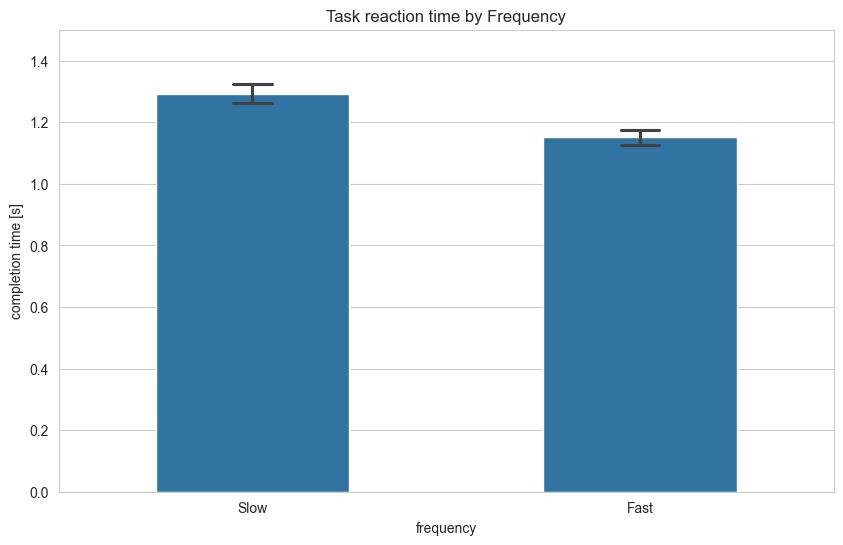

In [67]:
# Reaction time
plt.figure(figsize=(10,6))
ax=sns.barplot(
    data=gui_df,
    y='reaction_time',
    x = 'frequency',
    estimator='mean',
    order=['Slow', 'Fast'],
    errorbar='se',
    capsize=0.1,
    width=0.5,
)
plt.title('Task reaction time by Frequency')
plt.xlabel('frequency')
plt.ylabel('completion time [s]')
plt.ylim(0, 1.5)
plt.show()

### 2. Assumptions check

##### Univariate Normality

In [68]:
# Shapiro-Wilk test
def check_normality(data, dependent_vars, group_vars):
    for var in dependent_vars:
        print(f"Normality test for {var}:")
        for name, group in data.groupby(group_vars):
            stat, p = shapiro(group[var])
            print(f'  Group {name} -> stat={stat:.3f}, p={p:.3f}')
            if p > 0.05:
                print(f"  Group {name} is normally distributed (p > 0.05)")
            else:
                print(f"  Group {name} is not normally distributed (p <= 0.05)")
            print()
        print()
        print()

check_normality(df, dependent_vars, group_vars)

Normality test for errors:
  Group ('Easy', 'Fast') -> stat=0.680, p=0.000
  Group ('Easy', 'Fast') is not normally distributed (p <= 0.05)

  Group ('Easy', 'Slow') -> stat=0.506, p=0.000
  Group ('Easy', 'Slow') is not normally distributed (p <= 0.05)

  Group ('Hard', 'Fast') -> stat=0.709, p=0.000
  Group ('Hard', 'Fast') is not normally distributed (p <= 0.05)

  Group ('Hard', 'Slow') -> stat=0.864, p=0.000
  Group ('Hard', 'Slow') is not normally distributed (p <= 0.05)



Normality test for completion_time:
  Group ('Easy', 'Fast') -> stat=0.834, p=0.000
  Group ('Easy', 'Fast') is not normally distributed (p <= 0.05)

  Group ('Easy', 'Slow') -> stat=0.770, p=0.000
  Group ('Easy', 'Slow') is not normally distributed (p <= 0.05)

  Group ('Hard', 'Fast') -> stat=0.839, p=0.000
  Group ('Hard', 'Fast') is not normally distributed (p <= 0.05)

  Group ('Hard', 'Slow') -> stat=0.713, p=0.000
  Group ('Hard', 'Slow') is not normally distributed (p <= 0.05)



Normality test for re

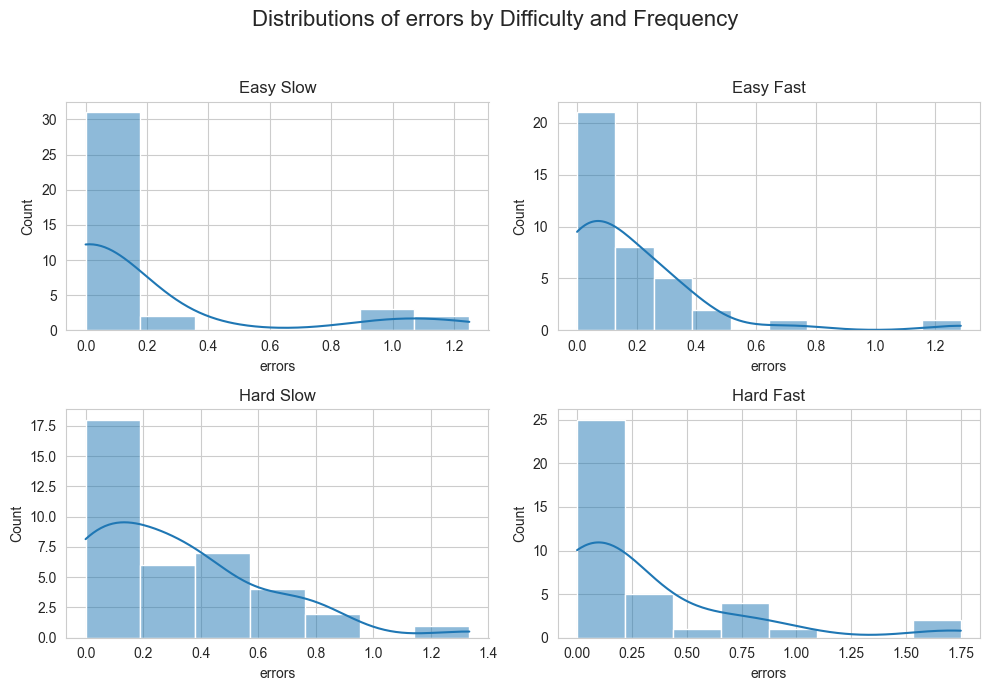

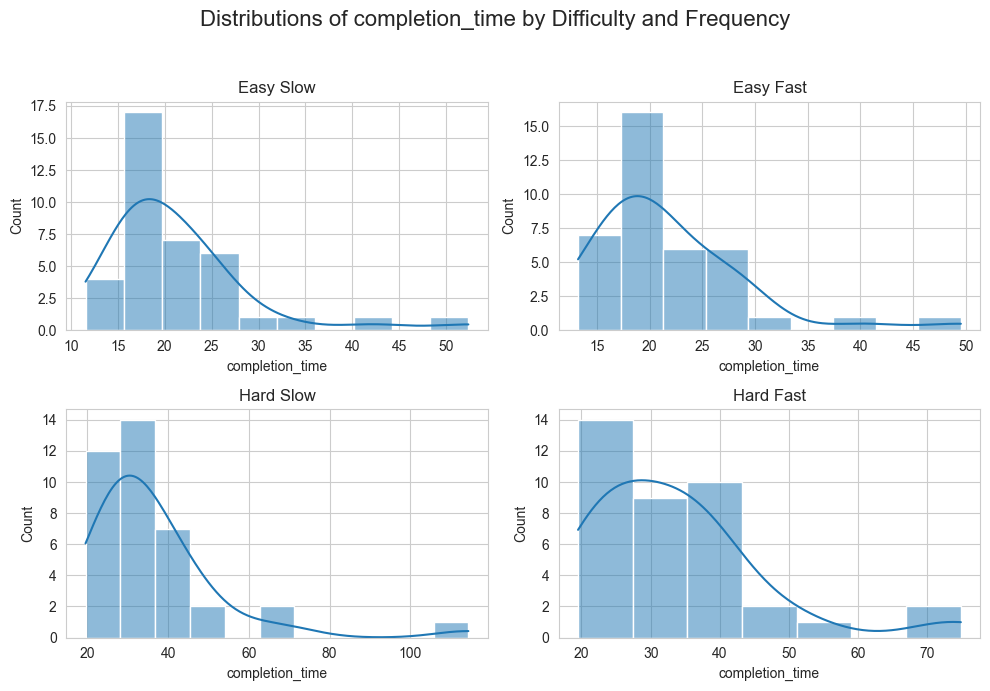

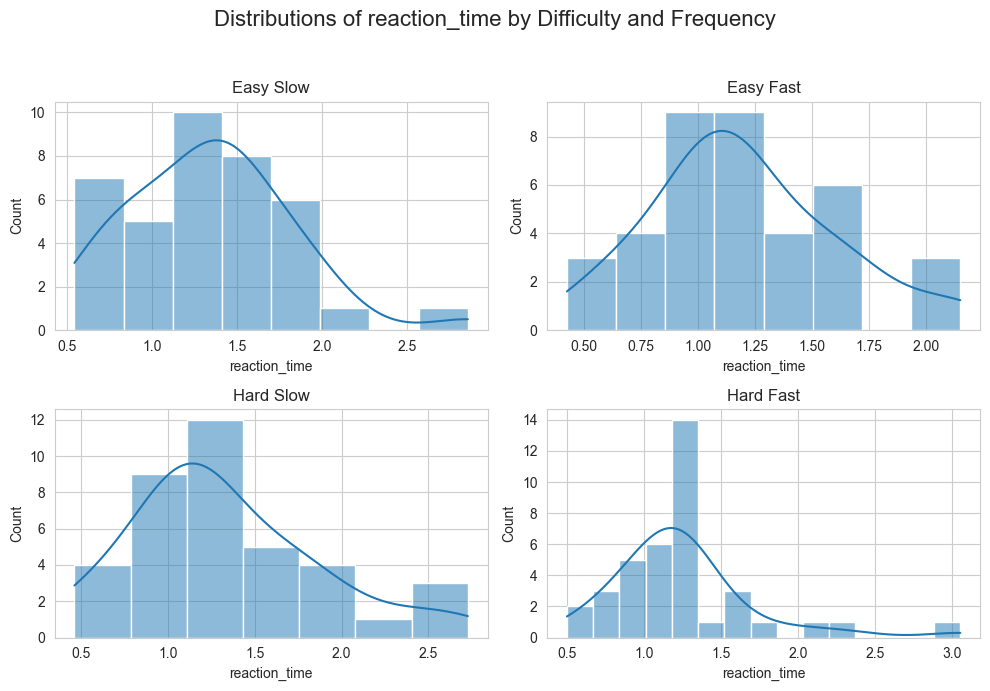

In [69]:
# Plot distributions
df_long['group'] = df_long['difficulty'].astype(str) + ' - ' + df_long['frequency'].astype(str)

def plot_distributions(data, dependent_vars):
    for var in dependent_vars:
        fig, axes = plt.subplots(2, 2, figsize=(10, 7))  # Create a 2x2 grid of subplots
        fig.suptitle(f"Distributions of {var} by Difficulty and Frequency", fontsize=16)
        
        axes_positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
        idx = 0
        
        for diff in data['difficulty'].unique():
            for freq in data['frequency'].unique():
                row, col = axes_positions[idx]
                subset = data[(data['difficulty'] == diff) & (data['frequency'] == freq)]
                sns.histplot(data=subset, x=var, kde=True, ax=axes[row, col])
                axes[row, col].set_title(f'{diff} {freq}')
                idx += 1
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

plot_distributions(df, dependent_vars)

In [70]:
# Normalization
dependent_vars_norm = ['errors_norm', 'completion_time_norm', 'reaction_time_norm']
df['errors_norm'], _ = stats.boxcox(df['errors'] + 1)
df['completion_time_norm'], _ = stats.boxcox(df['completion_time'] + 1)
df['reaction_time_norm'], _ = stats.boxcox(df['reaction_time'] + 1)

df_long['errors_norm'], _ = stats.boxcox(df_long['errors'] + 1)
df_long['completion_time_norm'], _ = stats.boxcox(df_long['completion_time'] + 1)
df_long['reaction_time_norm'], _ = stats.boxcox(df_long['reaction_time'] + 1)

check_normality(df, dependent_vars_norm, group_vars)

Normality test for errors_norm:
  Group ('Easy', 'Fast') -> stat=0.894, p=0.002
  Group ('Easy', 'Fast') is not normally distributed (p <= 0.05)

  Group ('Easy', 'Slow') -> stat=0.558, p=0.000
  Group ('Easy', 'Slow') is not normally distributed (p <= 0.05)

  Group ('Hard', 'Fast') -> stat=0.887, p=0.001
  Group ('Hard', 'Fast') is not normally distributed (p <= 0.05)

  Group ('Hard', 'Slow') -> stat=0.860, p=0.000
  Group ('Hard', 'Slow') is not normally distributed (p <= 0.05)



Normality test for completion_time_norm:
  Group ('Easy', 'Fast') -> stat=0.975, p=0.554
  Group ('Easy', 'Fast') is normally distributed (p > 0.05)

  Group ('Easy', 'Slow') -> stat=0.966, p=0.305
  Group ('Easy', 'Slow') is normally distributed (p > 0.05)

  Group ('Hard', 'Fast') -> stat=0.964, p=0.263
  Group ('Hard', 'Fast') is normally distributed (p > 0.05)

  Group ('Hard', 'Slow') -> stat=0.979, p=0.682
  Group ('Hard', 'Slow') is normally distributed (p > 0.05)



Normality test for reaction_tim

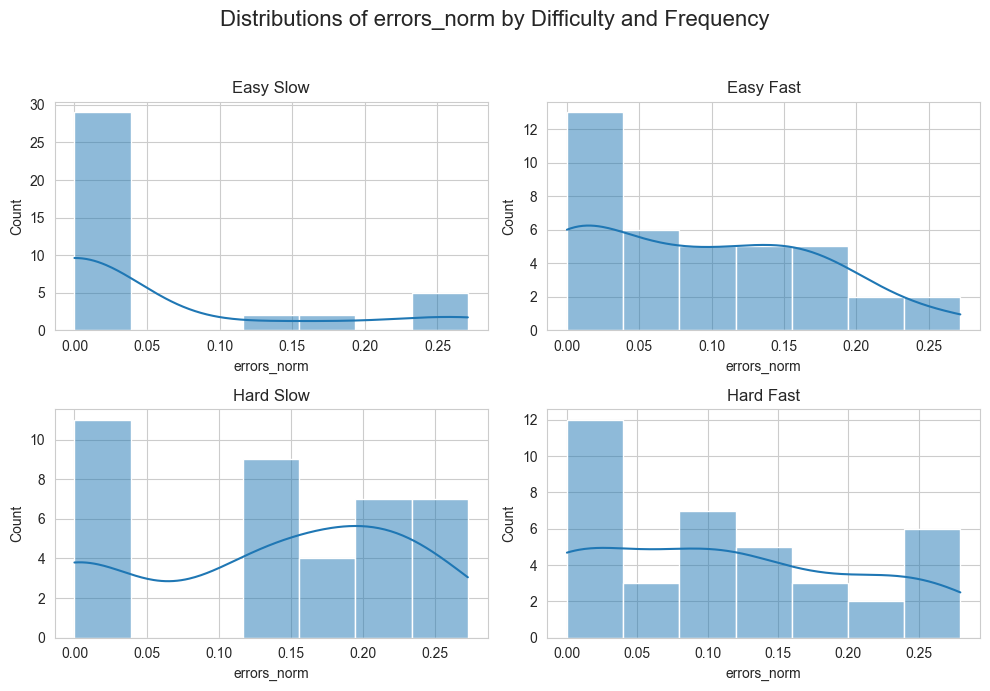

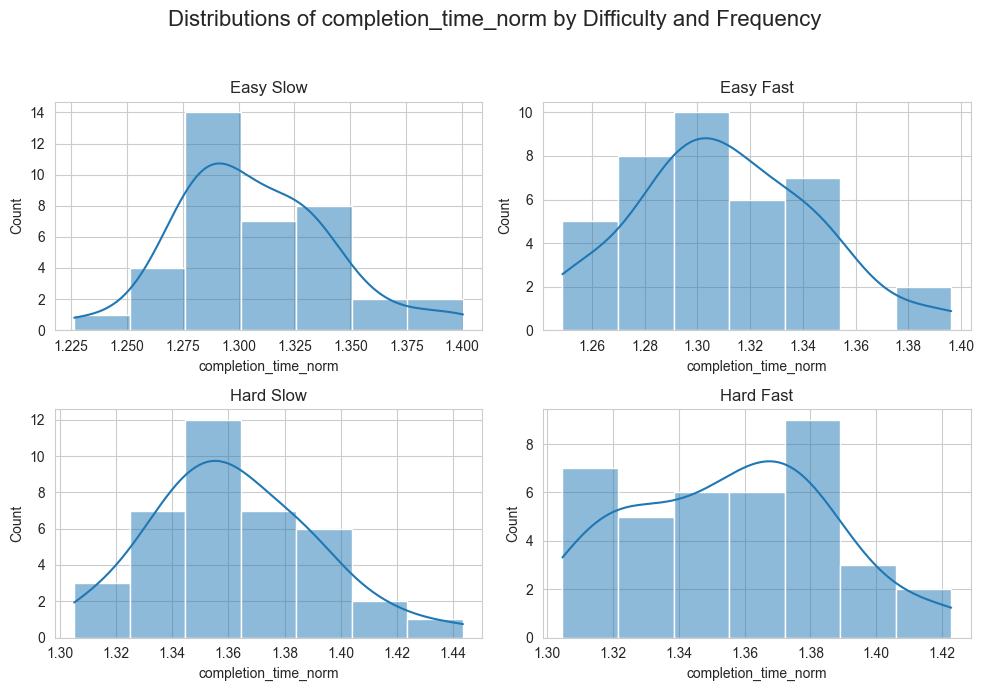

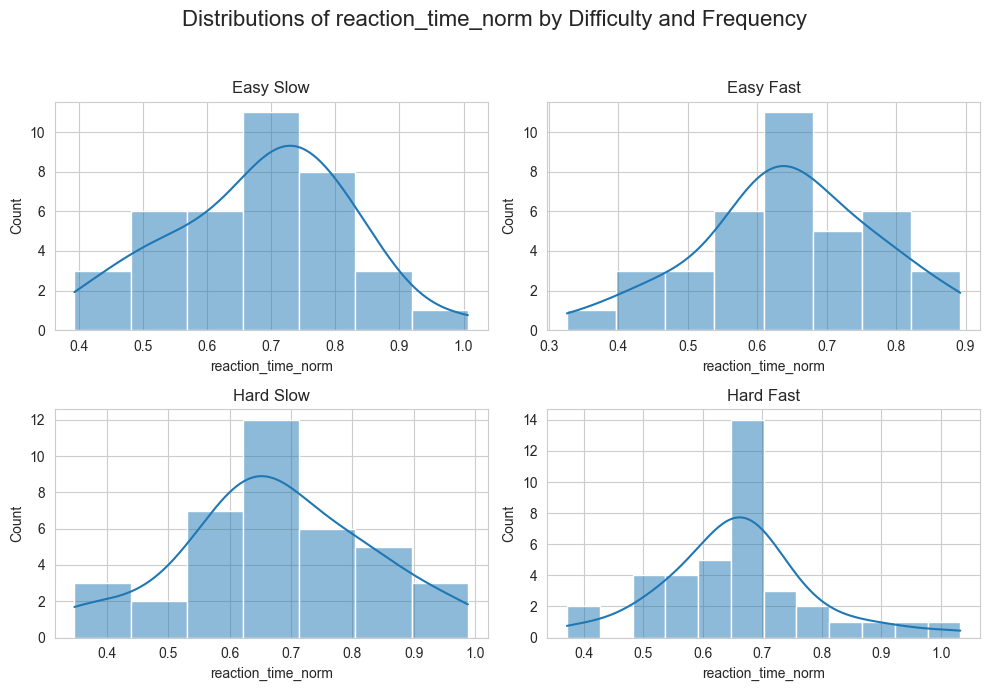

In [71]:
# Plot normalized distributions
plot_distributions(df, dependent_vars_norm)

##### Homogeneity of Variances

In [72]:
# Levene's test
def check_homogeneity_of_variance(data, dependent_vars, group_vars):
    for var in dependent_vars:
        print(f"Levene's test for {var}:")
        groups = [group[var] for name, group in data.groupby(group_vars)]
        stat, p = levene(*groups)
        print(f'  stat={stat:.3f}, p={p:.3f}')
        if p > 0.05:
            print(f"  Homogeneity of variance holds for {var} (p > 0.05)")
        else:
            print(f"  Homogeneity of variance does not hold for {var} (p <= 0.05)")

# Example usage:
check_homogeneity_of_variance(df, dependent_vars_norm, group_vars)

Levene's test for errors_norm:
  stat=1.940, p=0.126
  Homogeneity of variance holds for errors_norm (p > 0.05)
Levene's test for completion_time_norm:
  stat=0.346, p=0.792
  Homogeneity of variance holds for completion_time_norm (p > 0.05)
Levene's test for reaction_time_norm:
  stat=0.784, p=0.505
  Homogeneity of variance holds for reaction_time_norm (p > 0.05)


##### Multicollinearity

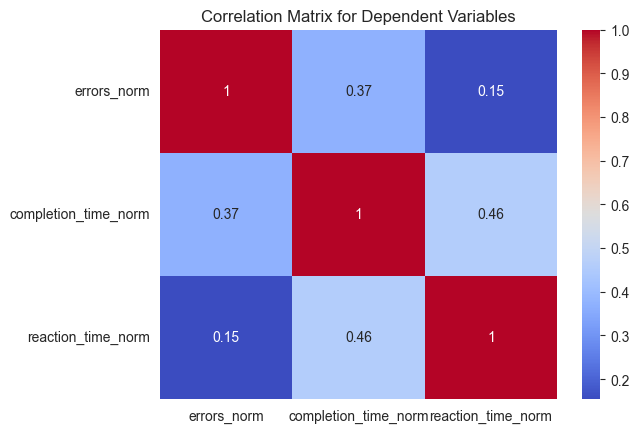

In [73]:
# correlation matrix
corr_matrix = df[dependent_vars_norm].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix for Dependent Variables")
plt.show()

### 3. Factorial Repeated Measures ANOVA (and ART)
Difficulty & Frequency

##### Errors (ART-ANOVA)

In [74]:
# Export dataset for R
df_long.to_csv('./aoi_data/gui_perf_R.csv', index=False)

In [75]:
# ART Results
print("Aligned Rank Transform of Factorial Model")
print("\nCall:")
print("art(formula = errors_norm ~ difficulty * frequency + (1 | participant_id),")
print("\tdata = df)")
print("\nColumn sums of aligned responses (should all be ~0):")
print("\t\t  difficulty            frequency difficulty:frequency ")
print("\t\t\t   0                    0                    0")
print("\nF values of ANOVAs on aligned responses not of interest (should all be ~0):")
print("|  Min. | 1st Qu. |  Median |    Mean | 3rd Qu. |    Max. |")
print("|     0 |       0 |       0 |       0 |       0 |       0 |")

Aligned Rank Transform of Factorial Model

Call:
art(formula = errors_norm ~ difficulty * frequency + (1 | participant_id),
	data = df)

Column sums of aligned responses (should all be ~0):
		  difficulty            frequency difficulty:frequency 
			   0                    0                    0

F values of ANOVAs on aligned responses not of interest (should all be ~0):
|  Min. | 1st Qu. |  Median |    Mean | 3rd Qu. |    Max. |
|     0 |       0 |       0 |       0 |       0 |       0 |


In [76]:
# ANOVA Results (from R) 
print("Analysis of Variance of Aligned Rank Transformed Data")
print("\nTable Type: Analysis of Deviance Table (Type III Wald F tests with Kenward-Roger df)")
print("Model: Mixed Effects (lmer)")
print("Response: art(errors_norm)")
print("\n| Effect                 | F-value  | df   | Df.res   | Pr(>F)   |")
print("|------------------------|----------|------|----------|----------|")
print("| difficulty             | 18.348   | 1    | 130      | 7.61e-05 | ***")
print("| frequency              |  1.149   | 1    | 130      | 0.28859  | ")
print("| difficulty:frequency   | 14.951   | 1    | 130      | 0.00030  | ***")
print("---")
print("Signif. codes:   0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1")

Analysis of Variance of Aligned Rank Transformed Data

Table Type: Analysis of Deviance Table (Type III Wald F tests with Kenward-Roger df)
Model: Mixed Effects (lmer)
Response: art(errors_norm)

| Effect                 | F-value  | df   | Df.res   | Pr(>F)   |
|------------------------|----------|------|----------|----------|
| difficulty             | 18.348   | 1    | 130      | 7.61e-05 | ***
| frequency              |  1.149   | 1    | 130      | 0.28859  | 
| difficulty:frequency   | 14.951   | 1    | 130      | 0.00030  | ***
---
Signif. codes:   0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [77]:
# Post-hoc Comparisons (from R)
# difficulty
print("= Main Effect of Difficulty =")
print("NOTE: Results may be misleading due to involvement in interactions")
print("| Contrast      | Estimate | SE   | df | t.ratio | p.value |")
print("|---------------|----------|------|----|---------|---------|")
print("| Easy vs Hard  | -15.1    | 3.51 | 54 | -4.283  | 0.0001  |")
print("\nResults are averaged over the levels of: frequency")
print("Degrees-of-freedom method: kenward-roger")

# frequency
print("\n\n= Main Effect of Frequency =")
print("NOTE: Results may be misleading due to involvement in interactions")
print("| Contrast      | Estimate | SE   | df | t.ratio | p.value |")
print("|---------------|----------|------|----|---------|---------|")
print("| Slow vs Fast  | -3.95    | 3.68 | 54 | -1.072  | 0.2886  |")
print("\nResults are averaged over the levels of: difficulty")
print("Degrees-of-freedom method: kenward-roger")

# interaction
print("\n\n= Interaction Effect (Difficulty × Frequency) =")
print("| Contrast                | Estimate | SE   | df | t.ratio | p.value |")
print("|-------------------------|----------|------|----|---------|---------|")
print("| Easy,Fast vs Easy,Slow  |  14.47   | 4.61 | 54 |  3.139  | 0.0142  |")
print("| Easy,Fast vs Hard,Fast  |  -4.00   | 4.61 | 54 | -0.867  | 0.8215  |")
print("| Easy,Fast vs Hard,Slow  |  -9.74   | 4.61 | 54 | -2.112  | 0.1624  |")
print("| Easy,Slow vs Hard,Fast  | -18.47   | 4.61 | 54 | -4.006  | 0.0011  |")
print("| Easy,Slow vs Hard,Slow  | -24.21   | 4.61 | 54 | -5.251  | <.0001  |")
print("| Hard,Fast vs Hard,Slow  |   5.74   | 4.61 | 54 | -1.244  | 0.6019  |")
print("\nDegrees-of-freedom method: kenward-roger")
print("P value adjustment: tukey method for comparing a family of 4 estimates")

= Main Effect of Difficulty =
NOTE: Results may be misleading due to involvement in interactions
| Contrast      | Estimate | SE   | df | t.ratio | p.value |
|---------------|----------|------|----|---------|---------|
| Easy vs Hard  | -15.1    | 3.51 | 54 | -4.283  | 0.0001  |

Results are averaged over the levels of: frequency
Degrees-of-freedom method: kenward-roger


= Main Effect of Frequency =
NOTE: Results may be misleading due to involvement in interactions
| Contrast      | Estimate | SE   | df | t.ratio | p.value |
|---------------|----------|------|----|---------|---------|
| Slow vs Fast  | -3.95    | 3.68 | 54 | -1.072  | 0.2886  |

Results are averaged over the levels of: difficulty
Degrees-of-freedom method: kenward-roger


= Interaction Effect (Difficulty × Frequency) =
| Contrast                | Estimate | SE   | df | t.ratio | p.value |
|-------------------------|----------|------|----|---------|---------|
| Easy,Fast vs Easy,Slow  |  14.47   | 4.61 | 54 |  3.139  |

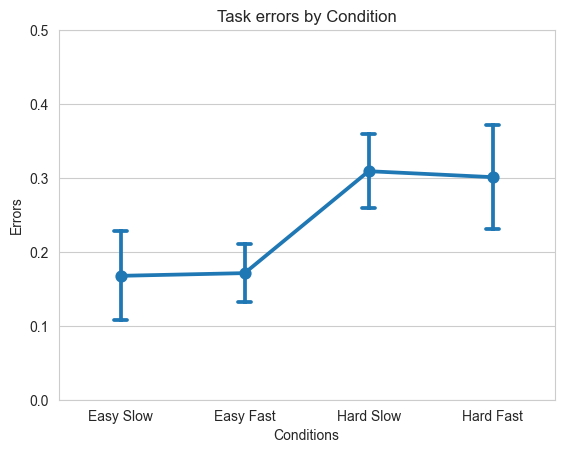

In [78]:
# Interaction plot with denormalized value
sns.pointplot(data=df, x='condition', y='errors', errorbar='se', markers='o', capsize=.1)
plt.title('Task errors by Condition')
plt.xlabel('Conditions')
plt.ylabel('Errors')
plt.ylim(0, .5)
plt.show()

##### Completion time

In [79]:
# Perform ANOVA
compl_anova_results = AnovaRM(data=df_long, depvar='completion_time_norm', subject='participant_id', 
                within=['difficulty', 'frequency']).fit()
print(compl_anova_results)

                       Anova
                     F Value  Num DF  Den DF Pr > F
---------------------------------------------------
difficulty           277.0725 1.0000 18.0000 0.0000
frequency              0.6134 1.0000 18.0000 0.4437
difficulty:frequency   5.2999 1.0000 18.0000 0.0335



In [80]:
# Post-hoc comparison (Tukey's HSD)
df_long['condition'] = df_long['difficulty'].astype(str) + '_' + df_long['frequency'].astype(str)
tukey = pairwise_tukeyhsd(endog=df_long['completion_time_norm'], groups=df_long['group'], alpha=0.05)
print(tukey)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
Easy - Fast Easy - Slow  -0.0014 0.9915  -0.014 0.0112  False
Easy - Fast Hard - Fast   0.0248    0.0  0.0122 0.0373   True
Easy - Fast Hard - Slow   0.0289    0.0  0.0163 0.0415   True
Easy - Slow Hard - Fast   0.0261    0.0  0.0136 0.0387   True
Easy - Slow Hard - Slow   0.0303    0.0  0.0177 0.0429   True
Hard - Fast Hard - Slow   0.0042 0.8215 -0.0084 0.0167  False
-------------------------------------------------------------


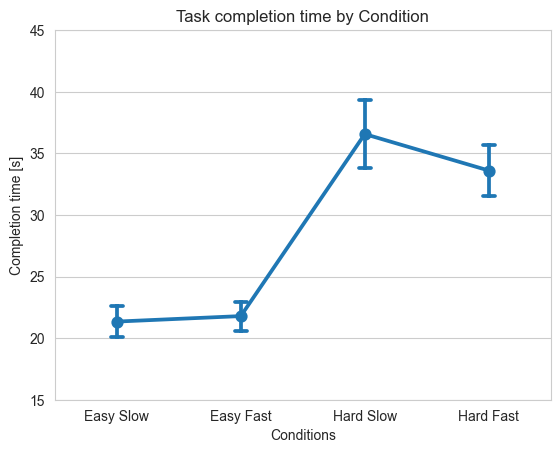

In [81]:
# Interaction plot with denormalized value
sns.pointplot(data=df, x='condition', y='completion_time', errorbar='se', markers='o', capsize=.1)
plt.title('Task completion time by Condition')
plt.xlabel('Conditions')
plt.ylabel('Completion time [s]')
plt.ylim(15, 45)
plt.show()

##### Reaction time

In [82]:
# Perform ANOVA
react_anova_results = AnovaRM(data=df_long, depvar='reaction_time_norm', subject='participant_id', 
                within=['difficulty', 'frequency']).fit()

print(react_anova_results)

                      Anova
                     F Value Num DF  Den DF Pr > F
--------------------------------------------------
difficulty            0.0140 1.0000 18.0000 0.9072
frequency             3.8454 1.0000 18.0000 0.0655
difficulty:frequency  1.2658 1.0000 18.0000 0.2753



In [83]:
# Post-hoc comparison (Tukey's HSD)
df_long['condition'] = df_long['difficulty'].astype(str) + '_' + df_long['frequency'].astype(str)
tukey = pairwise_tukeyhsd(endog=df_long['reaction_time_norm'], groups=df_long['group'], alpha=0.05)
print(tukey)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
Easy - Fast Easy - Slow   0.0441 0.7486 -0.0716 0.1599  False
Easy - Fast Hard - Fast   0.0142 0.9882 -0.1015   0.13  False
Easy - Fast Hard - Slow   0.0325 0.8816 -0.0833 0.1482  False
Easy - Slow Hard - Fast  -0.0299 0.9048 -0.1456 0.0859  False
Easy - Slow Hard - Slow  -0.0116 0.9935 -0.1274 0.1041  False
Hard - Fast Hard - Slow   0.0182 0.9758 -0.0975  0.134  False
-------------------------------------------------------------


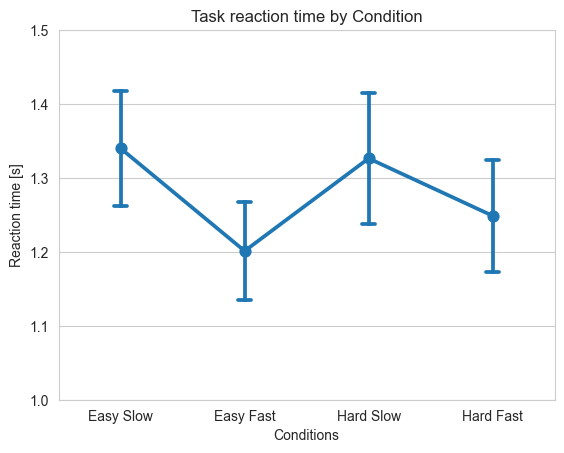

In [84]:
# Interaction plot with denormalized value
sns.pointplot(data=df, x='condition', y='reaction_time', errorbar='se', markers='o', capsize=.1)
plt.title('Task reaction time by Condition')
plt.xlabel('Conditions')
plt.ylabel('Reaction time [s]')
plt.ylim(1, 1.5)
plt.show()

### 4. Pairwise t-Tests
Difficulty, Frequency

##### Errors

In [85]:
# Difficulty
easy_errors = df_long[df_long['difficulty'] == 'Easy'].sort_values('participant_id')['errors_norm']
hard_errors = df_long[df_long['difficulty'] == 'Hard'].sort_values('participant_id')['errors_norm']

t_stat, p_value = stats.ttest_rel(easy_errors, hard_errors, alternative='less')
print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: -3.9075727671544462, P-value: 0.0001911827362551593


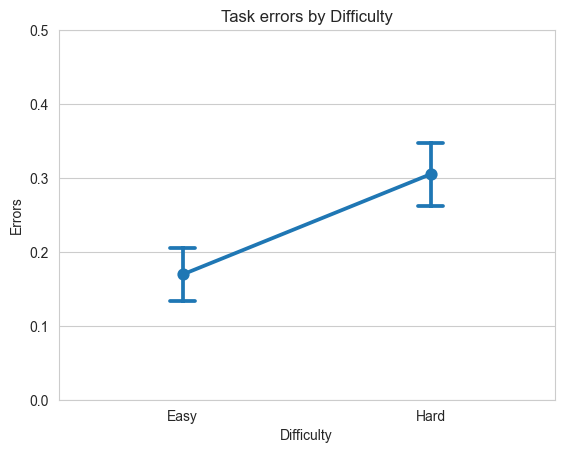

In [86]:
# Interaction plot with denormalized value
sns.pointplot(data=df, x='difficulty', y='errors', errorbar='se', markers='o', capsize=.1)
plt.title('Task errors by Difficulty')
plt.xlabel('Difficulty')
plt.ylabel('Errors')
plt.ylim(0, .5)
plt.show()

In [87]:
# Frequency
easy_errors = df_long[df_long['frequency'] == 'Slow'].sort_values('participant_id')['errors_norm']
hard_errors = df_long[df_long['frequency'] == 'Fast'].sort_values('participant_id')['errors_norm']

t_stat, p_value = stats.ttest_rel(easy_errors, hard_errors, alternative='less')
print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: -0.6941869674968532, P-value: 0.2459504475213738


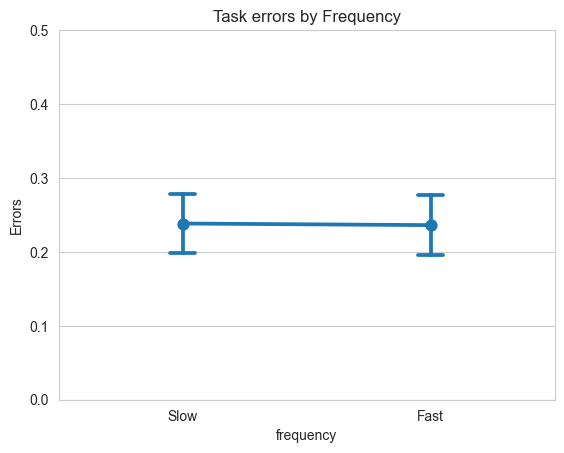

In [88]:
# Interaction plot with denormalized value
sns.pointplot(data=df, x='frequency', y='errors', errorbar='se', markers='o', capsize=.1)
plt.title('Task errors by Frequency')
plt.xlabel('frequency')
plt.ylabel('Errors')
plt.ylim(0, .5)
plt.show()

##### Completion time

In [89]:
# Difficulty
easy_errors = df_long[df_long['difficulty'] == 'Easy'].sort_values('participant_id')['completion_time_norm']
hard_errors = df_long[df_long['difficulty'] == 'Hard'].sort_values('participant_id')['completion_time_norm']

t_stat, p_value = stats.ttest_rel(easy_errors, hard_errors, alternative='less')
print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: -18.39449259610431, P-value: 1.6584433519391014e-20


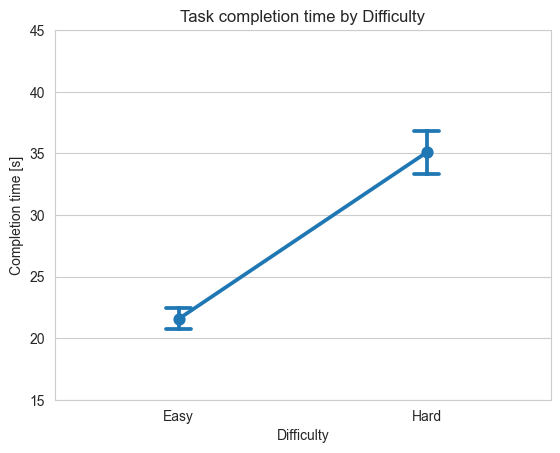

In [90]:
# Interaction plot with denormalized value
sns.pointplot(data=df, x='difficulty', y='completion_time', errorbar='se', markers='o', capsize=.1)
plt.title('Task completion time by Difficulty')
plt.xlabel('Difficulty')
plt.ylabel('Completion time [s]')
plt.ylim(15, 45)
plt.show()

In [91]:
# Frequency
easy_errors = df_long[df_long['frequency'] == 'Slow'].sort_values('participant_id')['completion_time_norm']
hard_errors = df_long[df_long['frequency'] == 'Fast'].sort_values('participant_id')['completion_time_norm']

t_stat, p_value = stats.ttest_rel(easy_errors, hard_errors, alternative='less')
print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: 0.8882529423721982, P-value: 0.8099285123805309


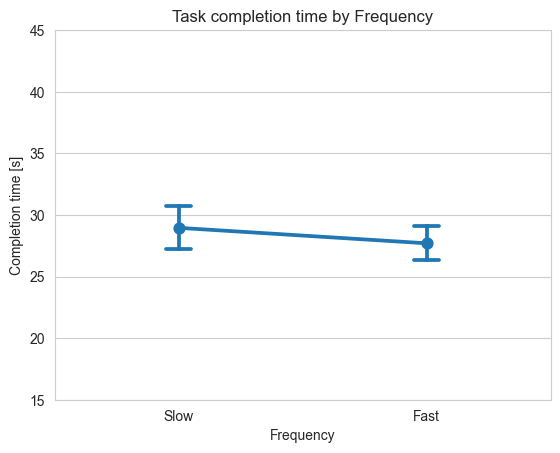

In [92]:
# Interaction plot with denormalized value
sns.pointplot(data=df, x='frequency', y='completion_time', errorbar='se', markers='o', capsize=.1)
plt.title('Task completion time by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Completion time [s]')
plt.ylim(15, 45)
plt.show()

##### Reaction time

In [93]:
# Difficulty
easy_errors = df_long[df_long['difficulty'] == 'Easy'].sort_values('participant_id')['reaction_time_norm']
hard_errors = df_long[df_long['difficulty'] == 'Hard'].sort_values('participant_id')['reaction_time_norm']

t_stat, p_value = stats.ttest_rel(easy_errors, hard_errors, alternative='greater')
print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: -0.11482456934457903, P-value: 0.545397473386287


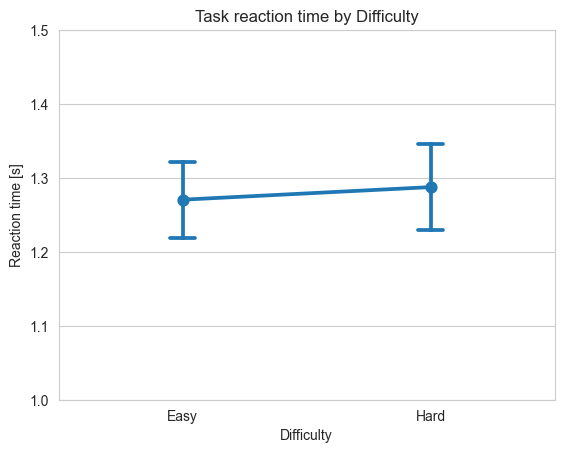

In [94]:
# Interaction plot with denormalized value
sns.pointplot(data=df, x='difficulty', y='reaction_time', errorbar='se', markers='o', capsize=.1)
plt.title('Task reaction time by Difficulty')
plt.xlabel('Difficulty')
plt.ylabel('Reaction time [s]')
plt.ylim(1, 1.5)
plt.show()

In [95]:
# Frequency
easy_errors = df_long[df_long['frequency'] == 'Slow'].sort_values('participant_id')['reaction_time_norm']
hard_errors = df_long[df_long['frequency'] == 'Fast'].sort_values('participant_id')['reaction_time_norm']

t_stat, p_value = stats.ttest_rel(easy_errors, hard_errors, alternative='greater')
print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: 2.251045518584829, P-value: 0.015205378139367901


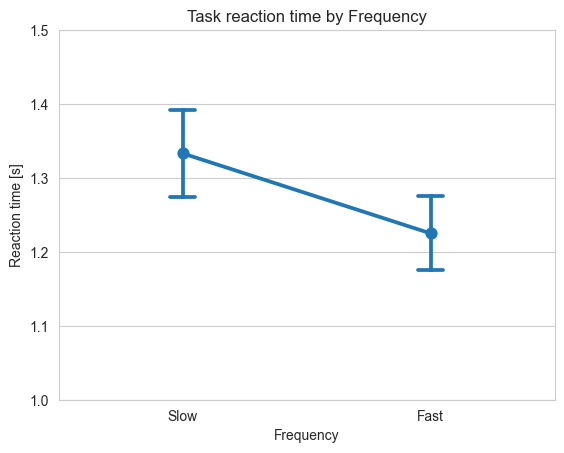

In [96]:
# Interaction plot with denormalized value
sns.pointplot(data=df, x='frequency', y='reaction_time', errorbar='se', markers='o', capsize=.1)
plt.title('Task reaction time by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Reaction time [s]')
plt.ylim(1, 1.5)
plt.show()

### 5. Results Table

##### ANOVA Results

In [3]:
# ANOVA Results Table
anova_data = {
    'Effect': ['Difficulty', 'Frequency', 'Difficulty:Frequency'],
    'Errors_p-value': [7.6093e-05, 0.28859466, 0.00029857],
    'Errors_Significance': ['***', '   ', '***'],
    'Completion_p-value': [2.231703e-12, 0.4436890, 0.03348195],
    'Completion_Significance': ['***', '   ', '  *'],
    'Reaction_p-value': [0.907168, 0.065541, 0.275340],
    'Reaction_Significance': ['   ', '  -', '   ']
}

df_anova = pd.DataFrame(anova_data)
df_anova.columns = pd.MultiIndex.from_tuples([
    ('', 'Effect'),
    ('(*) Errors', 'p-value'), ('(*) Errors', ''),
    ('Completion Time', 'p-value'), ('Completion Time', ''),
    ('Reaction Time', 'p-value'), ('Reaction Time', '')
])

df_anova.style.format({
    ('(*) Errors', 'p-value'): lambda x: "{:.1e}".format(x) if x < 0.001 else "{:.3f}".format(x),
    ('Completion Time', 'p-value'): lambda x: "{:.1e}".format(x) if x < 0.001 else "{:.3f}".format(x),
    ('Reaction Time', 'p-value'): lambda x: "{:.1e}".format(x) if x < 0.001 else "{:.3f}".format(x)
}).set_caption("Combined ANOVA Results for Performance Metrics"
).set_table_styles({
    ('(*) Errors', 'p-value'): [{'selector': 'th', 'props': [('text-align', 'left')]}],
    ('Completion Time', 'p-value'): [{'selector': 'th', 'props': [('text-align', 'left')]}],
    ('Reaction Time', 'p-value'): [{'selector': 'th', 'props': [('text-align', 'left')]}],
}, overwrite=False)

##### Pairwise T-Tests Results

In [98]:
# Pairwise T-Tests Results Table
ttest_data = {
    'Effect': ['Difficulty', 'Frequency'],
    'Contrast': ['Easy vs Hard', 'Slow vs Fast'],
    'Errors_p-value': [0.0001911827362551593, 0.2459504475213738],
    'Errors_Significance': ['***', '  '],
    'Completion_p-value': [1.6584433519391014e-20, 0.8099285123805309,],
    'Completion_Significance': ['***', '   '],
    'Reaction_p-value': [0.545397473386287, 0.015205378139367901],
    'Reaction_Significance': ['   ', '  *'],
}

df_ttest = pd.DataFrame(ttest_data)
df_ttest.columns = pd.MultiIndex.from_tuples([
    ('', 'Effect'), ('', 'Contrast'),
    ('Errors', 'p-value'), ('Errors', ''),
    ('Completion Time', 'p-value'), ('Completion Time', ''),
    ('Reaction Time', 'p-value'), ('Reaction Time', '')
])

df_ttest.style.format({
    ('Errors', 'p-value'): lambda x: "{:.1e}".format(x) if x < 0.001 else "{:.4f}".format(x),
    ('Completion Time', 'p-value'): lambda x: "{:.1e}".format(x) if x < 0.001 else "{:.4f}".format(x),
    ('Reaction Time', 'p-value'): lambda x: "{:.1e}".format(x) if x < 0.001 else "{:.4f}".format(x)
}).set_caption("Combined T-Test Results for Performance Metrics"
).set_table_styles({
    ('Errors', 'p-value'): [{'selector': 'th', 'props': [('text-align', 'left')]}],
    ('Completion Time', 'p-value'): [{'selector': 'th', 'props': [('text-align', 'left')]}],
    ('Reaction Time', 'p-value'): [{'selector': 'th', 'props': [('text-align', 'left')]}],
}, overwrite=False)


##### Graphs

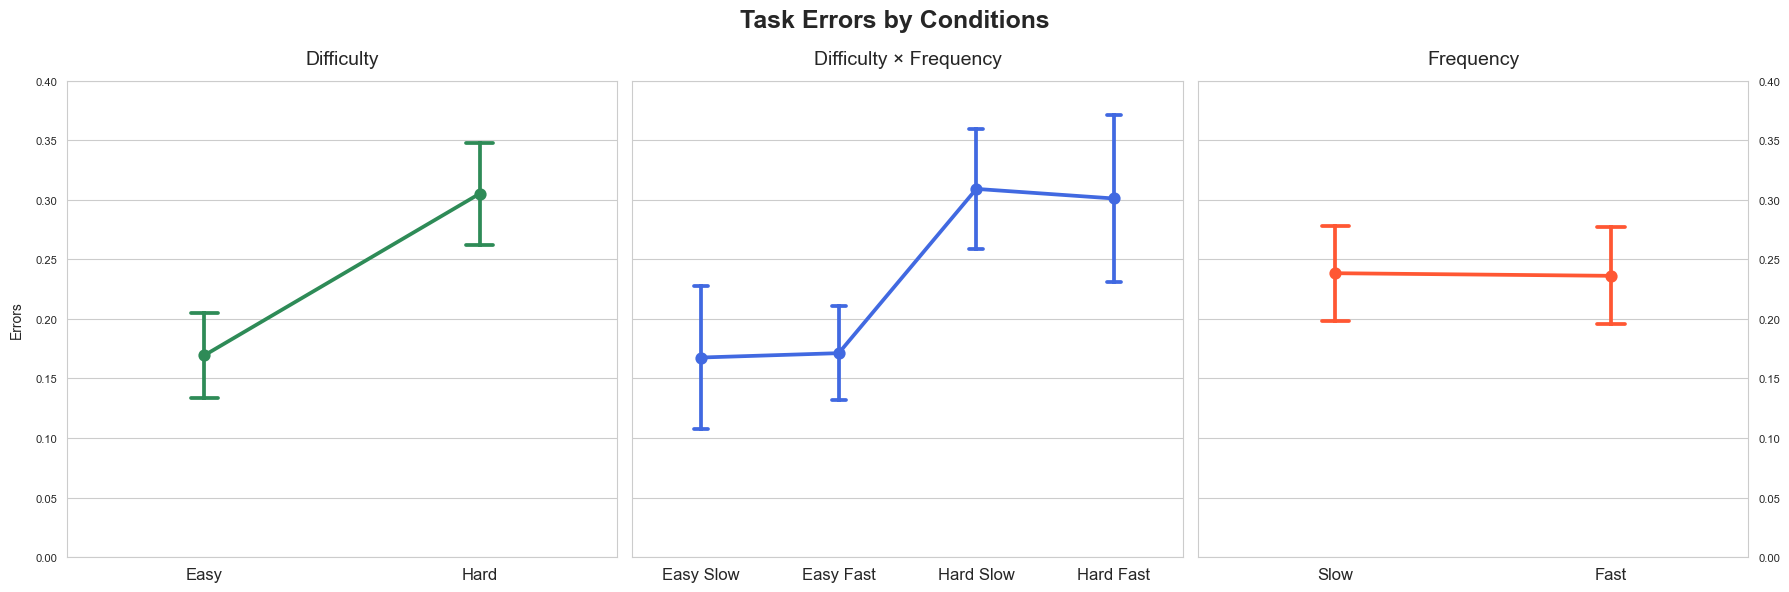

In [99]:
# Errors
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Task Errors by Conditions', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df, x='difficulty', y='errors', errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Errors', fontsize=10, labelpad=8)
axes[0].set_ylim(0, .4)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=8)

# difficulty & frequency
sns.pointplot(ax=axes[1], data=df, x='condition', y='errors', errorbar='se', markers='o', capsize=.1, color=colors[1])
axes[1].set_title('Difficulty × Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, .4)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelleft=False)

# frequency
sns.pointplot(ax=axes[2], data=df, x='frequency', y='errors', errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[2].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_ylim(0, .4)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=8, labelleft=False, labelright=True)


plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

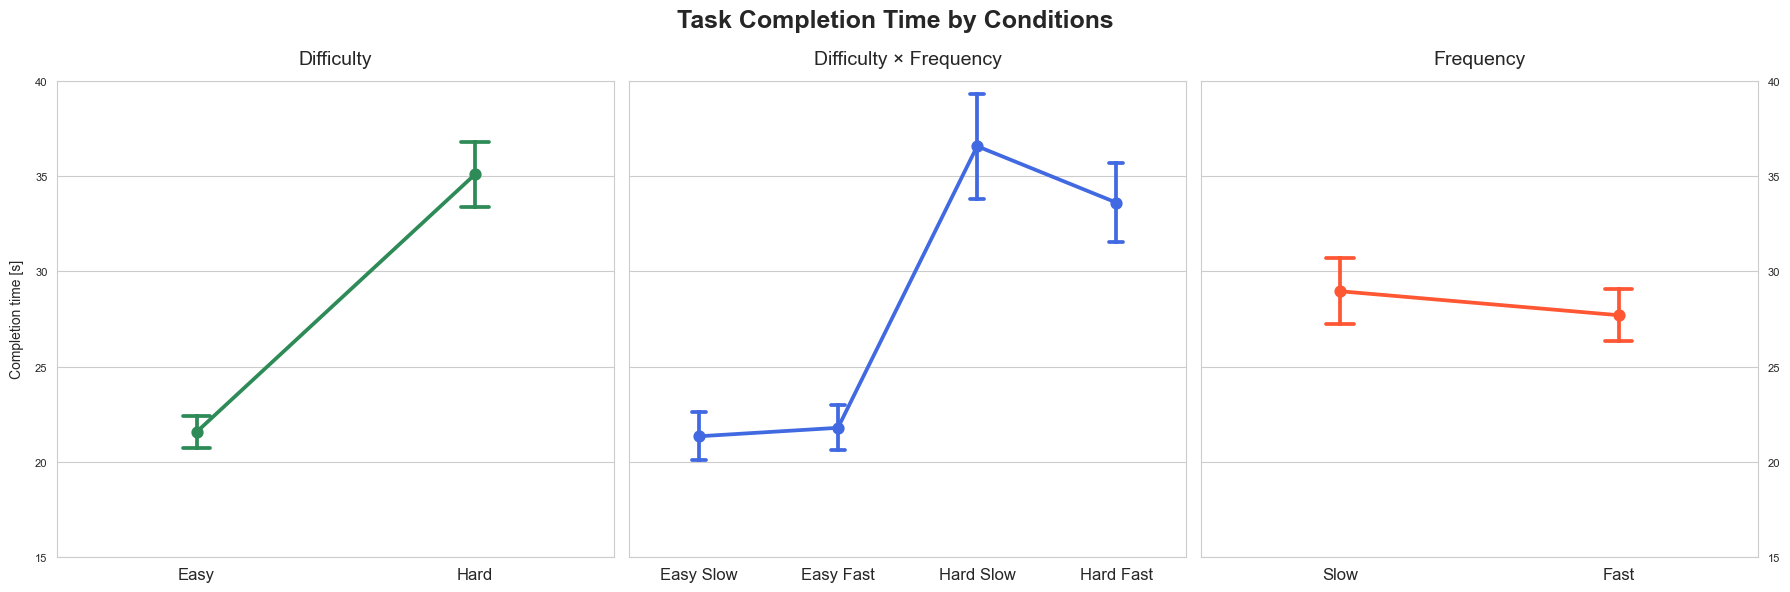

In [100]:
# Completion time
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Task Completion Time by Conditions', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df, x='difficulty', y='completion_time', errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Completion time [s]', fontsize=10, labelpad=8)
axes[0].set_ylim(15, 40)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=8)

# difficulty & frequency
sns.pointplot(ax=axes[1], data=df, x='condition', y='completion_time', errorbar='se', markers='o', capsize=.1, color=colors[1])
axes[1].set_title('Difficulty × Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(15, 40)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelleft=False)

# frequency
sns.pointplot(ax=axes[2], data=df, x='frequency', y='completion_time', errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[2].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_ylim(15, 40)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=8, labelleft=False, labelright=True)


plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

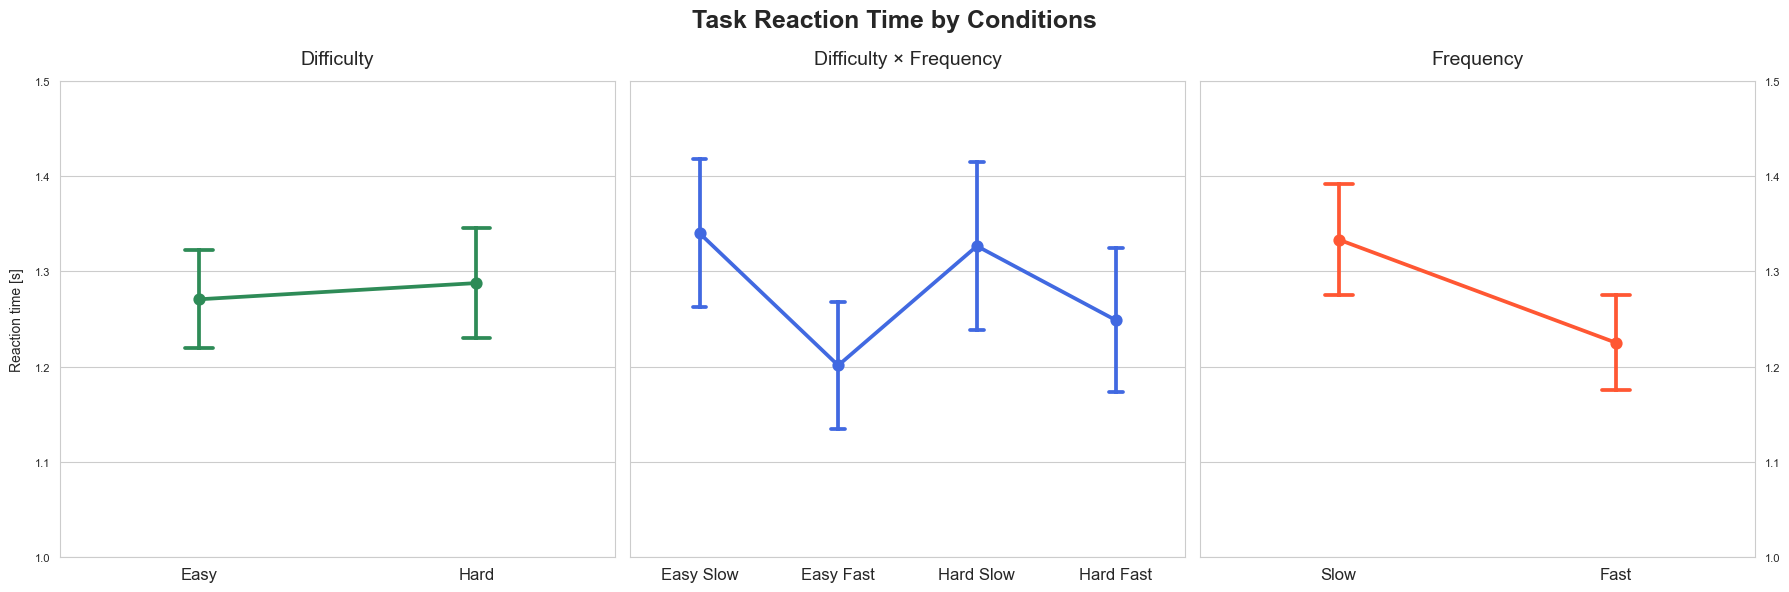

In [101]:
# Reaction time
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Task Reaction Time by Conditions', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df, x='difficulty', y='reaction_time', errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Reaction time [s]', fontsize=10, labelpad=8)
axes[0].set_ylim(1, 1.5)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=8)

# difficulty & frequency
sns.pointplot(ax=axes[1], data=df, x='condition', y='reaction_time', errorbar='se', markers='o', capsize=.1, color=colors[1])
axes[1].set_title('Difficulty × Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(1, 1.5)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelleft=False)

# frequency
sns.pointplot(ax=axes[2], data=df, x='frequency', y='reaction_time', errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[2].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].set_ylim(1, 1.5)
axes[2].tick_params(axis='x', labelsize=12)
axes[2].tick_params(axis='y', labelsize=8, labelleft=False, labelright=True)


plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

##### Graphs2

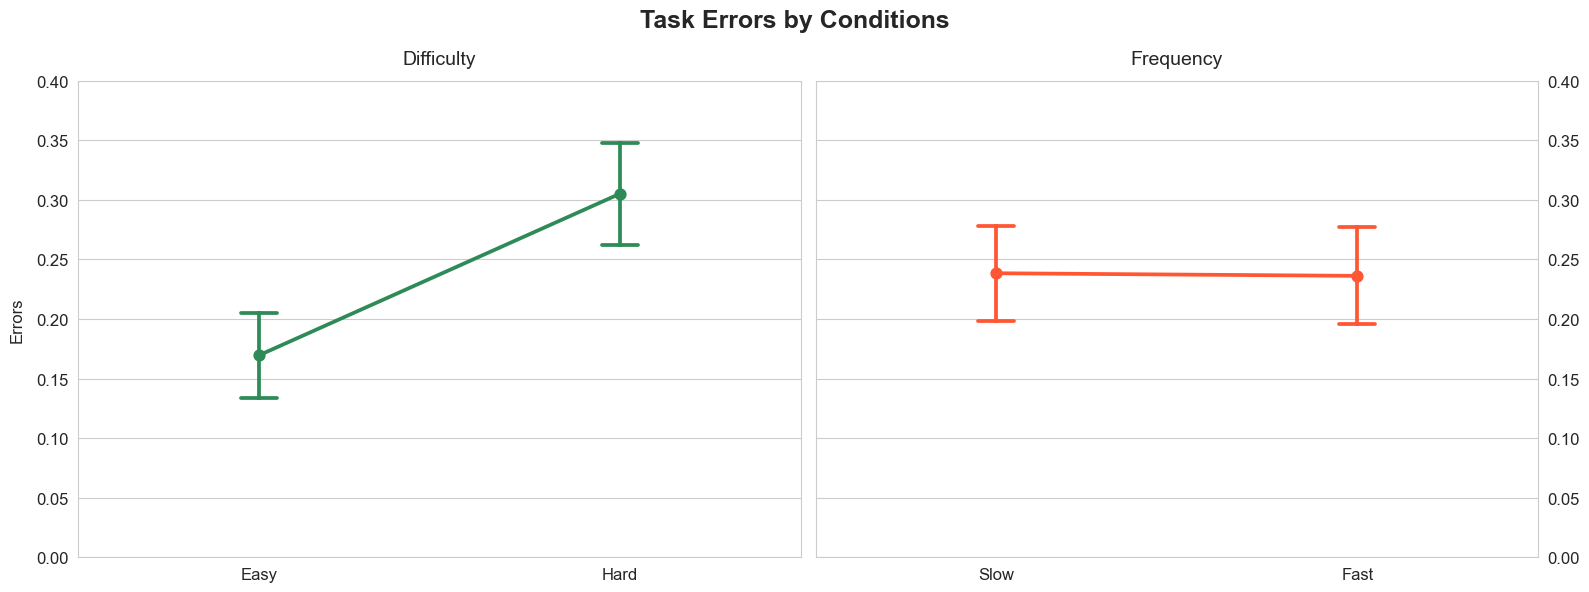

In [11]:
# Errors
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Task Errors by Conditions', fontsize=18, weight='bold')
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df, x='difficulty', y='errors', errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Errors', fontsize=12, labelpad=8)
axes[0].set_ylim(0, .4)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# frequency
sns.pointplot(ax=axes[1], data=df, x='frequency', y='errors', errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[1].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(0, .4)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12, labelleft=False, labelright=True)


plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

In [13]:
# Summary Stats
mean = df.query("difficulty == 'Easy'")['errors'].mean()
se = df.query("difficulty == 'Easy'")['errors'].sem()
print(f"Easy = {mean:.3f} (~{se:.3f})")

mean = df.query("difficulty == 'Hard'")['errors'].mean()
se = df.query("difficulty == 'Hard'")['errors'].sem()
print(f"Hard = {mean:.3f} (~{se:.3f})")

mean = df.query("frequency == 'Slow'")['errors'].mean()
se = df.query("frequency == 'Slow'")['errors'].sem()
print(f"Slow = {mean:.3f} (~{se:.3f})")

mean = df.query("frequency == 'Fast'")['errors'].mean()
se = df.query("frequency == 'Fast'")['errors'].sem()
print(f"Fast = {mean:.3f} (~{se:.3f})")

Easy = 0.169 (~0.036)
Hard = 0.305 (~0.043)
Slow = 0.238 (~0.040)
Fast = 0.236 (~0.041)


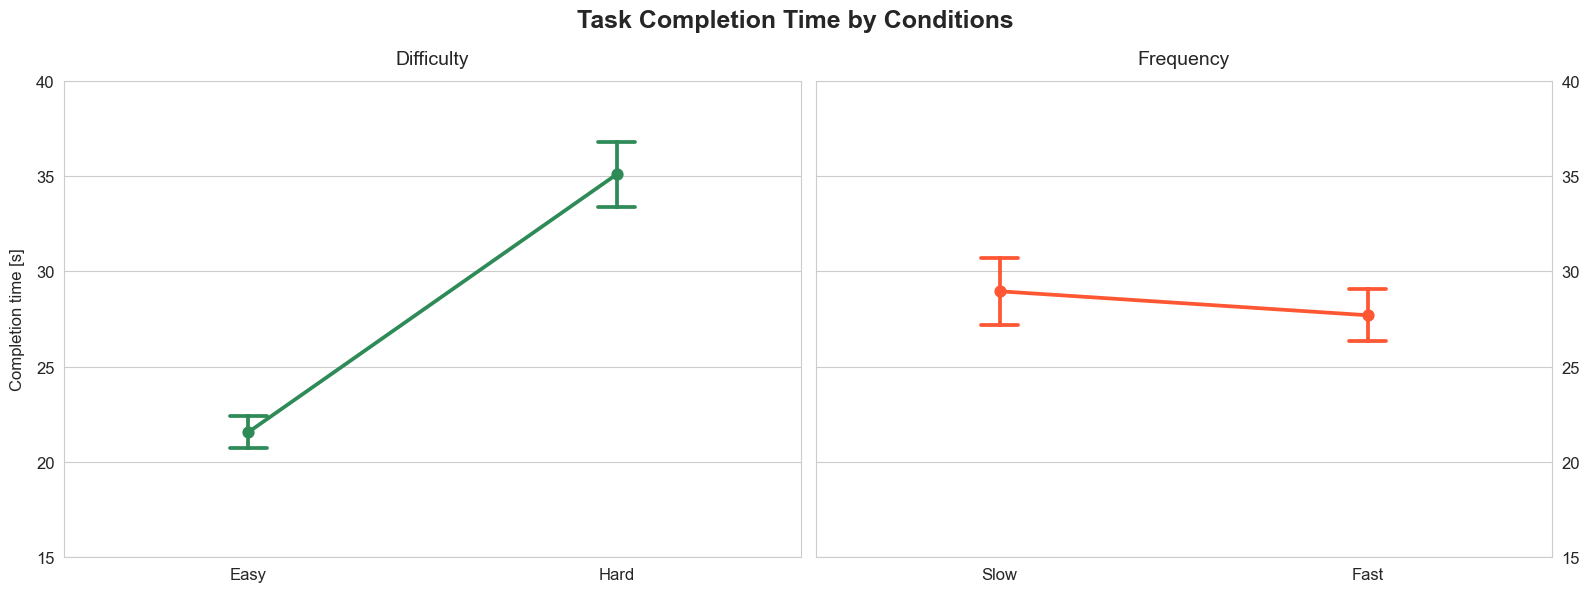

In [10]:
# Completion time
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Task Completion Time by Conditions', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df, x='difficulty', y='completion_time', errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Completion time [s]', fontsize=12, labelpad=8)
axes[0].set_ylim(15, 40)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# frequency
sns.pointplot(ax=axes[1], data=df, x='frequency', y='completion_time', errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[1].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(15, 40)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12, labelleft=False, labelright=True)


plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

In [15]:
# Summary Stats
mean = df.query("difficulty == 'Easy'")['completion_time'].mean()
se = df.query("difficulty == 'Easy'")['completion_time'].sem()
print(f"Easy = {mean:.3f} (~{se:.3f})")

mean = df.query("difficulty == 'Hard'")['completion_time'].mean()
se = df.query("difficulty == 'Hard'")['completion_time'].sem()
print(f"Hard = {mean:.3f} (~{se:.3f})")

mean = df.query("frequency == 'Slow'")['completion_time'].mean()
se = df.query("frequency == 'Slow'")['completion_time'].sem()
print(f"Slow = {mean:.3f} (~{se:.3f})")

mean = df.query("frequency == 'Fast'")['completion_time'].mean()
se = df.query("frequency == 'Fast'")['completion_time'].sem()
print(f"Fast = {mean:.3f} (~{se:.3f})")

Easy = 21.566 (~0.856)
Hard = 35.082 (~1.726)
Slow = 28.953 (~1.744)
Fast = 27.696 (~1.369)


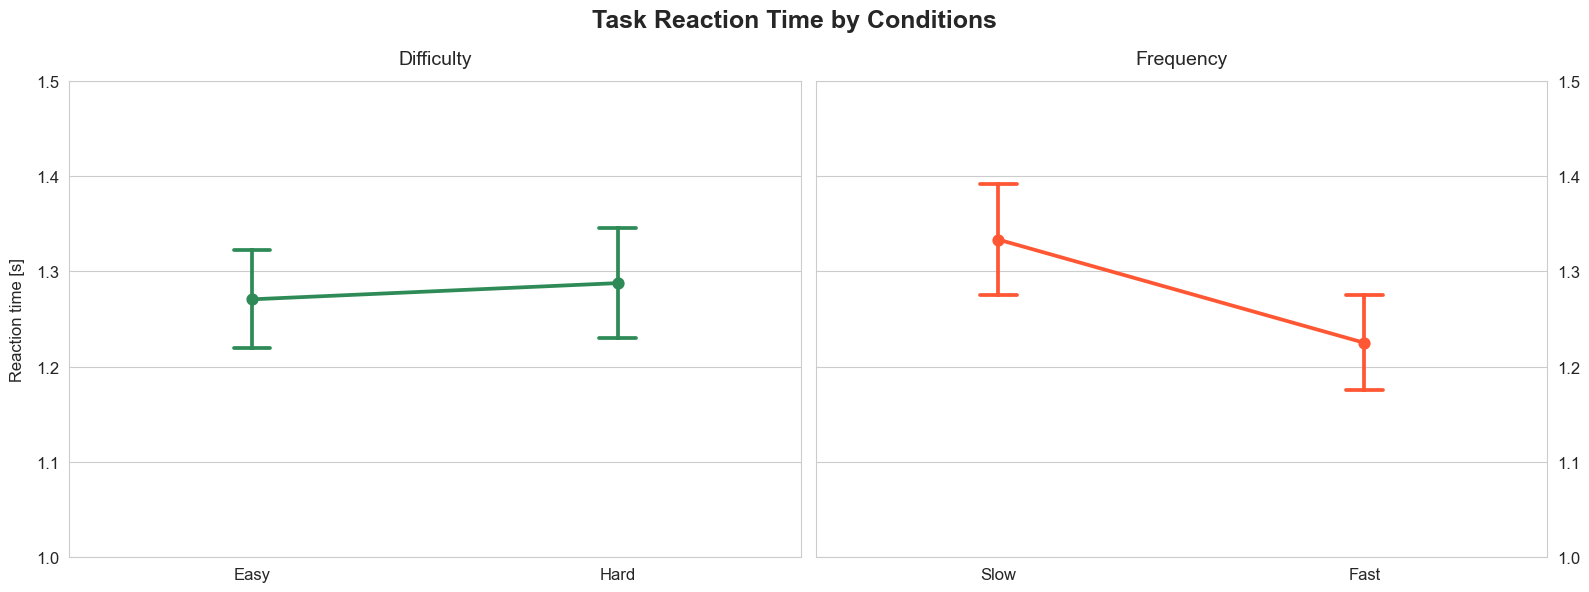

In [9]:
# Reaction time
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Task Reaction Time by Conditions', fontsize=18, weight='bold')
sns.set_style("whitegrid")
colors = ['#2E8B57', '#4169E1', '#FF5733']

# difficulty
sns.pointplot(ax=axes[0], data=df, x='difficulty', y='reaction_time', errorbar='se', markers='o', capsize=.1, color=colors[0])
axes[0].set_title('Difficulty', fontsize=14, weight='medium', pad=12)
axes[0].set_xlabel('')
axes[0].set_ylabel('Reaction time [s]', fontsize=12, labelpad=8)
axes[0].set_ylim(1, 1.5)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# frequency
sns.pointplot(ax=axes[1], data=df, x='frequency', y='reaction_time', errorbar='se', markers='o', capsize=.1, color=colors[2])
axes[1].set_title('Frequency', fontsize=14, weight='medium', pad=12)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_ylim(1, 1.5)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12, labelleft=False, labelright=True)


plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

In [16]:
# Summary Stats
mean = df.query("difficulty == 'Easy'")['reaction_time'].mean()
se = df.query("difficulty == 'Easy'")['reaction_time'].sem()
print(f"Easy = {mean:.3f} (~{se:.3f})")

mean = df.query("difficulty == 'Hard'")['reaction_time'].mean()
se = df.query("difficulty == 'Hard'")['reaction_time'].sem()
print(f"Hard = {mean:.3f} (~{se:.3f})")

mean = df.query("frequency == 'Slow'")['reaction_time'].mean()
se = df.query("frequency == 'Slow'")['reaction_time'].sem()
print(f"Slow = {mean:.3f} (~{se:.3f})")

mean = df.query("frequency == 'Fast'")['reaction_time'].mean()
se = df.query("frequency == 'Fast'")['reaction_time'].sem()
print(f"Fast = {mean:.3f} (~{se:.3f})")

Easy = 1.271 (~0.051)
Hard = 1.288 (~0.058)
Slow = 1.333 (~0.058)
Fast = 1.225 (~0.050)
